#### Решение дифференциального уравнения для затухающего гармонического осциллятора при помощи PINN

$
\begin{cases}
  \ddot{u} + 2 \delta \dot{u} + \omega_0^2 u = 0, \\
  u(0) = 1, \\
  \dot{u}(0) = 0,
\end{cases}
$

$
\mathrm{где}~~\delta = \mu / (2m)~,~\omega_0 = \sqrt{k / m}~.
$

Рассматривается случай с малыми затуханиями: $\delta < \omega_0$.

Точное решение:

$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{где}~~\omega=\sqrt{\omega_0^2 - \delta^2}~,~\phi = \arctan{(-\delta / \omega )}~,~ A = 1 / (2 \cos{(\phi)}) 
$

C:\Users\Alexey\AppData\Local\Temp\ipykernel_2832\4177868922.py:193: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax4.set(title="loss", xlabel='grad step', xlim=[0, n_epochs-1], ylim=[1e-5, 1])
C:\Users\Alexey\AppData\Local\Temp\ipykernel_2832\4177868922.py:202: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax6.set(title="$\\mathcal{L}_{r}^{i}$", xlabel="$i$", ylabel="$\\mathcal{L}_{r}^{i}$", ylim=[1e-5, 1])
100%|██████████| 10000/10000 [04:38<00:00, 35.92it/s, loss=0.000703, loss_r=0.000628, loss_ic=7.54e-5, lambda_r=1, lambda_ic=1]


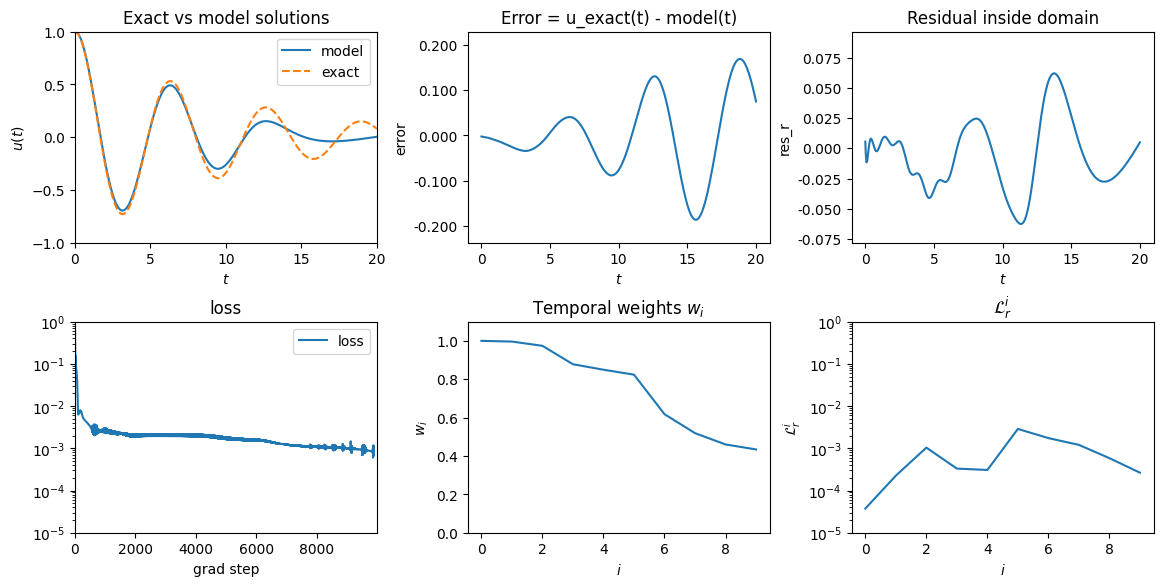

In [109]:
import time
from pathlib import Path
from datetime import datetime

import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.ticker as mticker
import numpy as np
from tqdm import trange

def compute_grad_theta_norm(model):
    grad_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            grad_norm += param.grad.norm(2).item()**2
    return grad_norm ** 0.5

def initialize_weights(model, scheme):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if scheme == 'naive':
                nn.init.normal_(layer.weight, mean=0.0, std=1.0)
                if layer.bias is not None:
                    nn.init.normal_(layer.bias, mean=0.0, std=1.0)
            elif scheme == 'glorot_uniform':
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            elif scheme == 'glorot_normal':
                nn.init.xavier_normal_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            else:
                raise ValueError(f"{scheme} is an unknown scheme for weights initialization")
            
def oscillator(delta, omega0, t):
    assert delta < omega0
    omega = np.sqrt(omega0**2 - delta**2)
    phi = np.arctan(-delta / omega)
    A = 1.0 / ( 2.0 * np.cos(phi) )
    return 2.0 * A * torch.exp(-delta * t) * torch.cos(phi + omega * t)
u_exact = lambda t: oscillator(delta=delta, omega0=omega0, t=t)

def smooth_autoscale_y_hysteresis(ax, y, pad=0.05, alpha_shrink=0.08):
    """
    Smoothly adjust the y-axis limits to follow streaming data.

    Each call computes target y-limits from the current data `y` (with a small
    padding), then updates the axes limits with hysteresis:
      - expand immediately if the new data exceeds the current limits (avoid clipping)
      - shrink gradually toward tighter limits (reduce jitter/"breathing")

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes whose y-limits will be updated.
    y : array-like
        Current y-data (list/NumPy array/torch tensor converted to array).
    pad : float, default=0.05
        Fractional padding added above and below the data range.
    alpha_shrink : float, default=0.08
        Smoothing factor for shrinking (0 < alpha <= 1). Smaller = smoother/slower.
    """
    y = np.asarray(y)
    ymin, ymax = np.nanmin(y), np.nanmax(y)
    if ymin == ymax:
        ymin -= 1.0
        ymax += 1.0

    yr = ymax - ymin
    ymin_t = ymin - pad * yr
    ymax_t = ymax + pad * yr

    cur_ymin, cur_ymax = ax.get_ylim()

    # Expand immediately if needed
    if ymin_t < cur_ymin:
        cur_ymin = ymin_t
    else:  # shrink slowly
        cur_ymin = (1 - alpha_shrink) * cur_ymin + alpha_shrink * ymin_t

    if ymax_t > cur_ymax:
        cur_ymax = ymax_t
    else:
        cur_ymax = (1 - alpha_shrink) * cur_ymax + alpha_shrink * ymax_t

    ax.set_ylim(cur_ymin, cur_ymax)

torch.manual_seed(2008)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 256), nn.Tanh(), 
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        n = self.net(x)
        return n #* x**2 * n + 1.0
model = MyNet().to(device)
initialize_weights(model, "glorot_normal")

# Problem definition
""" --- ОДНОМЕРНЫЙ ЗАТУХАЮЩИЙ ГАРМОНИЧЕСКИЙ ОСЦИЛЛЯТОР ---
u'' + 2 * delta * u' + omega0^2 * u = 0, где delta = mu/(2m), omega0 = sqrt(k/m)   (случай с затуханиями: delta < omega0)
u(0)  = 1,
u'(0) = 0.
u_exact(t) = 2 * A * exp(-delta * t) * cos(phi + omega * t), 
где omega = sqrt(omega0^2 - delta^2), 
    phi   = arctg(-delta/omega), 
    A     = 1 / (2 * cos(phi))"""
delta, omega0 = 0.1, 1
omega0_sq = omega0 * omega0
domain = [0, 20]    # t_min, t_max

# Training parameters
n_points = 1000
n_epochs = 10000
lambda_ic, lambda_r = 1, 1
causal_m = 10
causal_eps = 100

use_grad_norm_weighting = False
grad_norm_weighting_freq=200
grad_norm_weighting_alpha=0.9

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1.0/10000))

# Video
results_folder = Path.cwd() / 'runs' / "harmonic_oscillator_underdamped_1d"
results_folder.mkdir(exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
video_path = results_folder / ("training_animation_" + timestamp + ".mp4")
video_fps = 30
video_dpi = 100
video_render_freq = 100    # раз в сколько шагов градиентного спуска рендерить кадр 

t_ic = torch.tensor([[float(domain[0])]], device=device, requires_grad=True)
t_r = torch.rand((n_points, 1), device=device) * (domain[1] - domain[0]) + domain[0]
t_r.requires_grad_(True)

# Для логирования
loss_log = torch.zeros(n_epochs)
loss_r_log = torch.zeros(n_epochs)
loss_ic_log = torch.zeros(n_epochs)
lambda_r_log = [lambda_r]
lambda_ic_log = [lambda_ic]
W_log = dict()
L_t_log = dict()
W_logging_freq = video_render_freq

### ДЛЯ АНИМАЦИИ ПРОЦЕССА ОБУЧЕНИЯ
writer = anim.FFMpegWriter(
    fps=video_fps, 
    codec='libx264', 
    extra_args=['-pix_fmt', 'yuv420p', '-preset', 'ultrafast', "-threads", "0"]
)
w, h = plt.rcParams['figure.figsize']
w *= 0.6
h *= 0.6

# u_exact(t) and model(t)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(3*w, 2*h), constrained_layout=True)
t = torch.linspace(*domain, 500, device=device).reshape(-1, 1)
(line1, ) = ax1.plot(t.detach().cpu(), model(t).detach().cpu(), label="model")
ax1.plot(t.detach().cpu(), u_exact(t).detach().cpu(), '--', label="exact")
ax1.set(title="Exact vs model solutions", xlabel="$t$", ylabel="$u(t)$", xlim=domain, ylim=[-1, 1])
ax1.legend()

# Error
u_exact_arr = u_exact(t).detach().cpu()
(line2, ) = ax2.plot(t.detach().cpu(), torch.zeros(t.shape))
ax2.set(title="Error = u_exact(t) - model(t)", xlabel="$t$", ylabel="error", ylim=[-0.5, 0.5])
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))

# Residual inside domain
t_r_sorted, t_r_idx = torch.sort(t_r.detach().cpu().flatten())
(line3, ) = ax3.plot(t_r_sorted, torch.zeros(t_r_sorted.shape))
ax3.set(title="Residual inside domain", xlabel="$t$", ylabel="res_r")
ax3.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))

# loss
(line4, ) = ax4.semilogy(np.arange(n_epochs), np.zeros(n_epochs), label='loss')
ax4.set(title="loss", xlabel='grad step', xlim=[0, n_epochs-1], ylim=[1e-5, 1])
ax4.legend()

# Temporal weights
(line5, ) = ax5.plot(np.arange(causal_m), np.zeros(causal_m))
ax5.set(title="Temporal weights $w_i$", xlabel="$i$", ylabel="$w_i$", ylim=[0, 1.1])

# L_t
(line6, ) = ax6.semilogy(np.arange(causal_m), np.zeros(causal_m))
ax6.set(title="$\\mathcal{L}_{r}^{i}$", xlabel="$i$", ylabel="$\\mathcal{L}_{r}^{i}$", ylim=[1e-5, 1])

pbar = trange(n_epochs)
with writer.saving(fig, video_path, dpi=video_dpi):
    for iter in pbar:
        u_r = model(t_r)
        u_ic = model(t_ic)

        du_dt = torch.autograd.grad(u_r, t_r, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
        d2u_dt2 = torch.autograd.grad(du_dt, t_r, grad_outputs=torch.ones_like(du_dt), create_graph=True)[0]
        res_r = d2u_dt2 + 2*delta*du_dt + omega0_sq*u_r
        res_ic1 = u_ic - torch.ones_like(u_ic)
        res_ic2 = torch.autograd.grad(u_ic, t_ic, grad_outputs=torch.ones_like(u_ic), create_graph=True)[0]

        loss_ic = torch.mean(res_ic1**2) + torch.mean(res_ic2**2)
        if use_grad_norm_weighting and iter % grad_norm_weighting_freq == 0:
            optimizer.zero_grad()
            loss_ic.backward(retain_graph=True)
            grad_loss_ic_theta_norm = compute_grad_theta_norm(model)

        t_flat = t_r.detach().squeeze(-1)

        L_t = torch.zeros(causal_m, device=device)
        h = (domain[1] - domain[0]) / causal_m
        for i in range(causal_m):
            mask = ((i * h < t_flat) & (t_flat <= (i + 1) * h))
            if mask.any():
                L_t[i] = torch.mean(res_r[mask]**2)
            else:
                L_t[i] = 0.0
        M = torch.tril(torch.ones(causal_m, causal_m, device=device), diagonal=-1)
        W = torch.exp(-causal_eps * (M @ L_t)).detach()
        loss_r = (W * L_t).mean()
        if use_grad_norm_weighting and iter % grad_norm_weighting_freq == 0:
            optimizer.zero_grad()
            loss_r.backward(retain_graph=True)
            grad_loss_r_theta_norm = compute_grad_theta_norm(model)

        if use_grad_norm_weighting and iter % grad_norm_weighting_freq == 0 and iter != 0:
            tmp = grad_loss_r_theta_norm + grad_loss_ic_theta_norm
            lambda_r = grad_norm_weighting_alpha*lambda_r + (1.0 - grad_norm_weighting_alpha) * tmp / grad_loss_r_theta_norm
            lambda_ic = grad_norm_weighting_alpha*lambda_ic + (1.0 - grad_norm_weighting_alpha) * tmp / grad_loss_ic_theta_norm

        loss = lambda_r * loss_r + lambda_ic * loss_ic

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()

        if iter % W_logging_freq == 0:
            W_log[iter] = W.detach().cpu()
            L_t_log[iter] = L_t.detach().cpu()
        
        if iter % 1 == 0:
            loss_log[iter] = loss.item()
            loss_r_log[iter] = loss_r.item()
            loss_ic_log[iter] = loss_ic.item()
            lambda_r_log.append(lambda_r)
            lambda_ic_log.append(lambda_ic)

        if iter % 100 == 0:
            pbar.set_postfix({
                'loss': loss.item(),
                'loss_r': loss_r.item(),
                'loss_ic': loss_ic.item(),
                'lambda_r': lambda_r,
                'lambda_ic': lambda_ic
            })

        # Рендер кадра анимации
        if iter % video_render_freq == 0:
            u_approx = model(t).detach().cpu()
            line1.set_ydata(model(t).detach().cpu())
            line2.set_ydata(u_exact_arr - u_approx)
            smooth_autoscale_y_hysteresis(ax2, line2.get_ydata())
            line3.set_ydata(res_r[t_r_idx].detach().cpu())
            smooth_autoscale_y_hysteresis(ax3, line3.get_ydata())
            line4.set_data(np.arange(iter + 1), loss_log[:iter+1])
            line5.set_ydata(W_log[iter])
            line6.set_ydata(L_t_log[iter])
            writer.grab_frame()

Losses

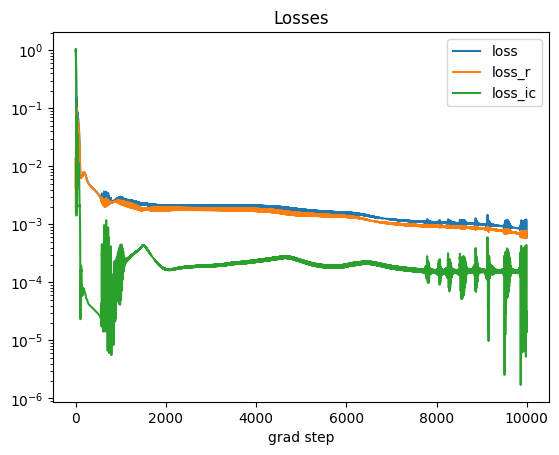

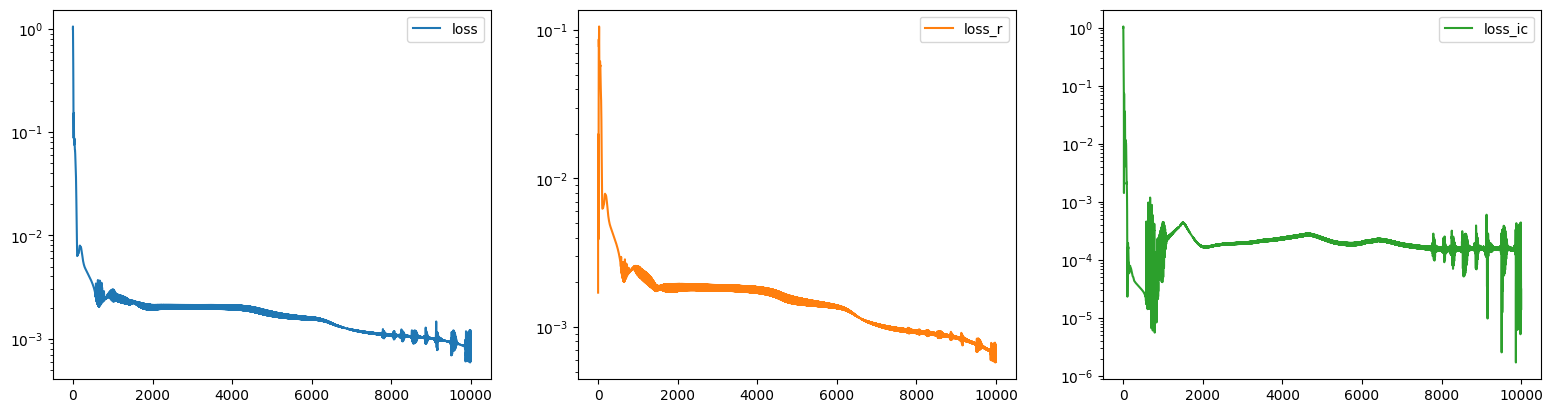

In [110]:
fig, ax = plt.subplots()
ax.set_title("Losses")
ax.set_xlabel("grad step")
ax.semilogy(loss_log, label="loss")
ax.semilogy(loss_r_log, label="loss_r")
ax.semilogy(loss_ic_log, label="loss_ic")
ax.legend()
plt.show()

w, h = plt.rcParams['figure.figsize']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*w, h))
ax1.semilogy(loss_log, label="loss", color='C0')
ax1.legend()
ax2.semilogy(loss_r_log, label="loss_r", color='C1')
ax2.legend()
ax3.semilogy(loss_ic_log, label="loss_ic", color='C2')
ax3.legend()
plt.show()

$\lambda$

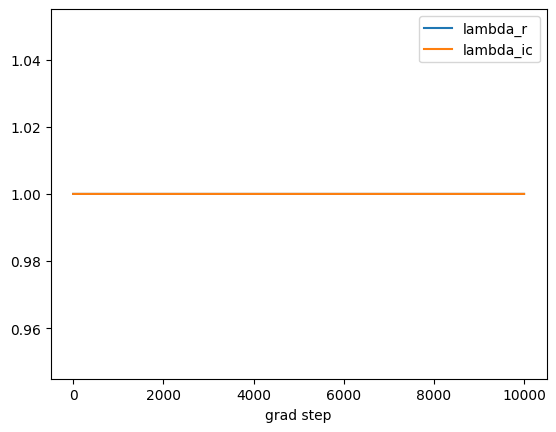

In [111]:
fig, ax = plt.subplots()
ax.plot(lambda_r_log, label="lambda_r")
ax.plot(lambda_ic_log, label="lambda_ic")
ax.set_xlabel("grad step")
ax.legend()
plt.show()

Temporal Weights $w_i$

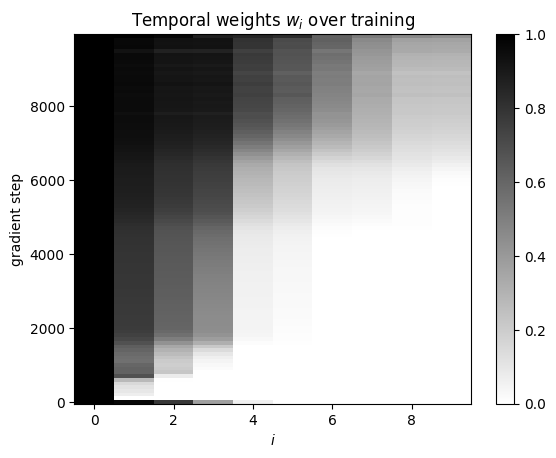

In [115]:
iters = np.array(sorted(W_log.keys()))
W_tmp = np.stack([W_log[it].detach().flatten().cpu().numpy() for it in iters])

t = np.arange(W_tmp.shape[1])

fig, ax = plt.subplots()
pm = ax.pcolormesh(t, iters, W_tmp, shading='auto', cmap='binary')
cbar = fig.colorbar(pm, ax=ax)

ax.set(title="Temporal weights $w_i$ over training", xlabel="$i$", ylabel="gradient step")
plt.show()

$L_r (t)$

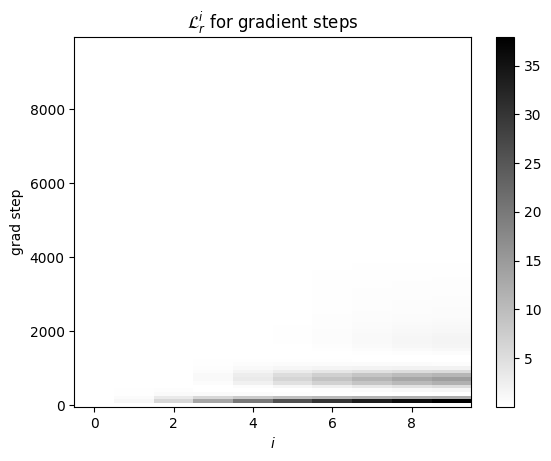

In [116]:
# fig, ax = plt.subplots()
# for iter, l in L_t_log.items():
#     ax.semilogy(l, 'o--', label=f"iter = {iter:5d}")
# ax.legend()
# ax.set_xlabel("time period id")
# ax.set_title("L_t for different epochs")
# plt.show()

iters = np.array(sorted(L_t_log.keys()))
L_t_tmp = np.stack([L_t_log[it].detach().flatten().cpu().numpy() for it in iters])

t = np.arange(L_t_tmp.shape[1])

fig, ax = plt.subplots()
pm = ax.pcolormesh(t, iters, L_t_tmp, shading='auto', cmap='binary')
cbar = fig.colorbar(pm, ax=ax)

ax.set(title="$\\mathcal{L}_{r}^{i}$ for gradient steps", xlabel="$i$", ylabel="grad step")
plt.show()

Model vs reference solution

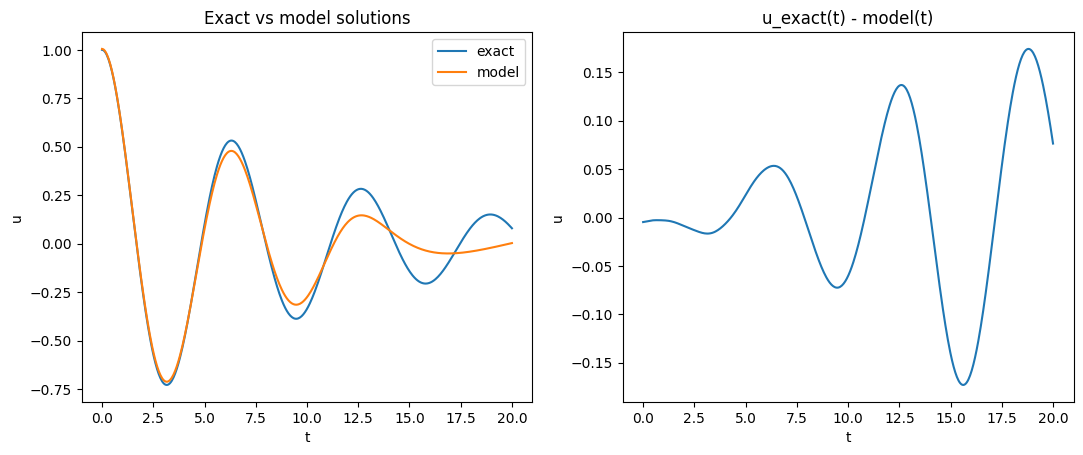

In [114]:
with torch.no_grad():
    model = model.to("cpu")
    t = torch.linspace(*domain, 500).reshape(-1, 1)

    w, h = plt.rcParams['figure.figsize']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*w, h))
    ax1.set_title("Exact vs model solutions")
    ax1.set_xlabel("t")
    ax1.set_ylabel("u")
    ax1.plot(t, u_exact(t), label="exact")
    ax1.plot(t, model(t), label="model")
    ax1.legend()
    ax2.plot(t, u_exact(t) - model(t))
    ax2.set_title("u_exact(t) - model(t)")
    ax2.set_xlabel("t")
    ax2.set_ylabel("u")
    plt.show()